In [25]:
import platform
import os
import subprocess
import pandas as pd

energibridge_executable = "release-energibridge/energibridge"

def run(file_name, no_runs=1):
    current_os = platform.system().lower()
    data = []
    
    if current_os == 'darwin':  # Mac OS
        current_directory = os.getcwd()
        path = os.path.join(current_directory, file_name)
        
        subprocess.run(['chmod', '+x', path ])
        # Run the temporary file with energibridge as a subprocess
        result = subprocess.run([energibridge_executable, '-o', 'temp.csv', '--summary', 'python3', path], capture_output=True,
                    text=True)
        print(result.stdout)
        print(result.stderr)
        # Check if the command executed successfully
        if result.returncode == 0:
            print("Command executed successfully.")
            # Load the data from temp.csv into the data variable
            try:
                data.append(pd.read_csv('temp.csv'))
                print("Data loaded successfully.")
            except Exception as e:
                print("Error loading data:", e)
        else:
            print("Error executing command.")

    elif current_os == 'windows':
        pass
    else:
        raise NotImplementedError(f"Unsupported operating system: {current_os}")

    return data

In [30]:
file_path = "youtube_test.py"
run(file_path)

Webpage opened. Waiting for 1 minute...
Browser closed.
Energy consumption in joules: 127.12686857700345 for 11.793186 sec of execution.


Command executed successfully.
Data loaded successfully.


[    Delta           Time  CPU_FREQUENCY_0  CPU_FREQUENCY_1  CPU_FREQUENCY_2  \
 0       0  1739463141713             4056             4056             4056   
 1     204  1739463141713             4056             4056             4056   
 2     204  1739463141918             4056             4056             4056   
 3     204  1739463142123             4056             4056             4056   
 4     204  1739463142328             4056             4056             4056   
 5     200  1739463142533             4056             4056             4056   
 6     203  1739463142734             4056             4056             4056   
 7     202  1739463142937             4056             4056             4056   
 8     204  1739463143141             4056             4056             4056   
 9     199  1739463143345             4056             4056             4056   
 10    201  1739463143545             4056             4056             4056   
 11    203  1739463143747             40

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def extract_time_and_power(data, cumulative=False):
    res = []
    index = 32 # if platform.system().lower() == 'darwin'
    # change the data to numpy array
    data = np.array(data)
    # keep only the power data and delta time
    time = data[:, 0]
    power = data[:, index]
    # make diff of power
    if not platform.system().lower() == 'darwin':
        power = np.diff(power)
        # insert 0 at the beginning
        power = np.insert(power, 0, 0)

    if cumulative:
        time = np.cumsum(time) / 1_000
        power = np.cumsum(power)
        power = power[0:-1]
        time = time[0:-1]
    else:
        power = power[1:-1]
        time = time[1:-1]
    #make numpy array from time and power
    res.append(np.column_stack((time, power)))
    return res

def make_time_series_plot(time_power_dataset, cumulative=False):
    for time_power in time_power_dataset:
        time = time_power[:, 0]
        power = time_power[:, 1]
        if not cumulative:
            # multiply power usage by delta time to get energy usage
            power = power * (time / 100)
            time = np.cumsum(time) / 1000
        plt.plot(time, power)
    # add legend
    plt.legend([f'Run {i+1}' for i in range(len(time_power_dataset))])
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')
    plt.title(f'Power vs Time, cumulative={cumulative}')
    plt.show()

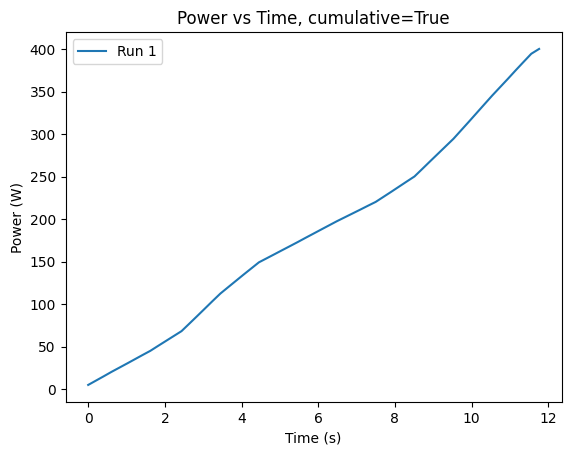

In [28]:
data = np.genfromtxt('temp.csv', delimiter=',', skip_header=1)
res = extract_time_and_power(data, cumulative=True)
make_time_series_plot(res, cumulative=True)

In [22]:
def make_violin_plot(time_power_dataset, std_dev=None):
    '''
    Make a violin plot of the energy consumption of the time_power_dataset
    :param time_power_dataset:
    :param std_dev: remove outliers that are more than std_dev standard deviations away from the mean
    :return:
    '''
    data = []
    # extract joul data from time_power_dataset
    for time_power in time_power_dataset:
        time = time_power_dataset[:, 0]
        power = time_power[:, 1]
        # multiply power usage by delta time to get energy usage
        power += power * (time / 1000)
        data.append(np.sum(power))
    if std_dev is not None:
        # get all indexes of data entries that are more than 3 standard deviations away from the mean
        outliers = np.where(np.abs(data - np.mean(data)) > 1 * np.std(data))
        # remove indexes from time_power_dataset
        data = np.delete(data, outliers, axis=0)
    fig, ax = plt.subplots()
    # Create the violin plot
    violins = ax.violinplot(
        data,
        showextrema=False)

    for pc in violins['bodies']:
        pc.set_facecolor('white')
        pc.set_edgecolor('black')
        pc.set_linewidth(0.6)
        pc.set_alpha(1)

    # Create the boxplot
    lineprops = dict(linewidth=0.5)
    medianprops = dict(color='black')
    ax.boxplot(
        data,
        whiskerprops=lineprops,
        boxprops=lineprops,
        medianprops=medianprops)

    # Style
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("Energy Consumption (J)")

    plt.show()

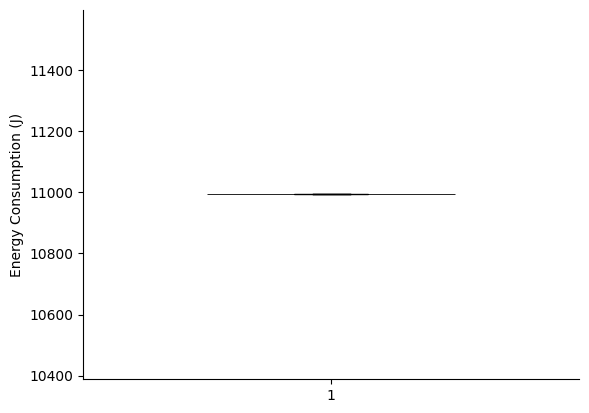

In [29]:
make_violin_plot(res)